In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('/Users/abefarkas/Project OB Data/data_set.csv')

In [3]:
data.head()

,Unnamed: 0,primary_key,bp1,bs1,bp2,bs2,bp3,bs3,bp4,bs4,...,ap16,as16,ap17,as17,ap18,as18,ap19,as19,ap20,as20
0,0,2022-05-19 00:00:15,28720.075362,3.772080,28719.533333,1.405377,28719.011594,0.626551,28718.371014,0.505087,...,28724.006522,0.418891,28724.167391,0.487558,28724.361594,0.706101,28724.511594,0.707326,28724.657971,1.104145
1,1,2022-05-19 00:00:45,28755.960345,1.878828,28755.570690,0.335776,28755.050000,0.573517,28754.684483,0.737259,...,28760.520690,7.383086,28760.674138,4.193586,28760.872414,0.620983,28761.067241,0.773897,28761.250000,0.854017
2,2,2022-05-19 00:01:15,28782.703333,1.771600,28782.131667,0.536867,28781.485000,0.402600,28781.140000,0.382467,...,28787.931667,0.427633,28788.138333,0.580383,28788.331667,0.421400,28788.506667,0.376617,28788.750000,0.425300
3,3,2022-05-19 00:01:45,28789.470000,1.767750,28788.766667,0.343217,28788.278333,0.243650,28788.046667,0.325300,...,28793.874833,0.486350,28794.093333,0.346800,28794.290000,1.161250,28794.483000,0.536067,28794.623333,0.395067
4,4,2022-05-19 00:02:15,28788.382759,1.634448,28787.839655,0.342845,28787.370690,0.396414,28787.039655,0.232483,...,28792.984483,0.383293,28793.143103,0.595362,28793.387931,0.417172,28793.587931,0.473741,28793.763793,0.417776


In [4]:
data.drop(['Unnamed: 0'], axis = 1, inplace = True) 

In [5]:
# data['primary_key'] = pd.to_datetime(data['primary_key'])

In [6]:
# data=data.set_index('primary_key')

In [7]:
data.index

RangeIndex(start=0, stop=2880, step=1)

In [8]:
# Weighted Average Price
data['WAP'] = (data['bp1']*data['bs1']
               +data['bp2']*data['bs2']
               +data['ap1']*data['as1']
               +data['ap2']*data['as2'])/(data['bs1']+
                                         data['bs2']+
                                         data['as1']+
                                         data['as2'])

In [9]:
# Bid Ask Spread
data['spread'] = ((data['ap1']/data['bp1']) - 1)

In [10]:
def log_price(list_stock_prices):
    return np.log(list_stock_prices)

In [11]:
data.insert(0, 'log_price', log_price(data['WAP']))

In [12]:
data['log_returns'] = data.log_price.diff()

In [13]:
def realized_volatility():
    list_vol = []
    i = 0
    for i in data.index:
        x = np.std(data.log_returns.iloc[:i])
        i += 1
        list_vol.append(x)
    
    return list_vol

In [14]:
data['realized_volatility'] = realized_volatility()

In [15]:
from sklearn.impute import SimpleImputer

In [16]:
imputer = SimpleImputer(strategy="constant", fill_value = 0) # Instantiate a SimpleImputer object with your strategy of choice

imputer.fit(data[['realized_volatility']]) # Call the "fit" method on the object

data['realized_volatility'] = imputer.transform(data[['realized_volatility']]) # Call the "transform" method on the object

imputer.statistics_ # The mean is stored in the transformer's memory

array([0.])

In [17]:
imputer2 = SimpleImputer(strategy="constant", fill_value = 0.001254)
imputer2.fit(data[['log_returns']]) # Call the "fit" method on the object

data['log_returns'] = imputer2.transform(data[['log_returns']]) # Call the "transform" method on the object

imputer2.statistics_ # The mean is stored in the transformer's memory

array([0.001254])

In [18]:
#sum of all bid quantities 2 levels of depth to try to mitigate costless spoofing in crypto
data['first2_bid_depth'] = data[['bs1', 'bs2']].sum(axis=1)      

In [19]:
#sum of all bid quantities 2 levels of depth to try to mitigate costless spoofing in crypto
data['first2_bid_depth'] = data[['bs1', 'bs2']].sum(axis=1)

In [20]:
#sum of all bid quantities
data['full_bid_depth'] = data[['bs1', 'bs2', 'bs3','bs4', 'bs5', 'bs6','bs7', 'bs8', 'bs9','bs10',
                         'bs11', 'bs12', 'bs13','bs14', 'bs15', 'bs16','bs17', 'bs18', 'bs19','bs20']].sum(axis=1)

In [21]:
#sum of all bid quantities
data['full_ask_depth'] = data[['as1', 'as2', 'as3','as4', 'as5', 'as6','as7', 'as8', 'as9','as10',
                         'as11', 'as12', 'as13','as14', 'as15', 'as16','as17', 'as18', 'as19','as20']].sum(axis=1)

In [22]:
#Order Flow Imbalance (OFI) 
#relative quantities of bids vs asks
#BBA depth (Best Bid/ASK, first level) OFI
data['BBAOFI'] = (data['bs1']-data['as1'])/(data['bs1']+data['as1'])

In [23]:
#OFI
#First 2 levels of depth to try to mitigate costless spoofing
data['First2OFI'] = ((data['bs1']+data['bs2']) - (data['as1']+data['as2'])) \
/ ((data['bs1']+data['bs2']) + (data['as1']+data['as2']))

In [24]:
#Order Flow Imbalance (OFI) 
#relative quantities of bids vs asks
#full depth (approx 20 levels) OFI
data['FDOFI'] = (data['full_bid_depth']-data['full_ask_depth'])/(data['full_bid_depth']+data['full_ask_depth'])

In [25]:
#Exponential Moving Averages of WAP
data['WAP_trend5'] = data['WAP'].ewm(span=2).mean()
data['WAP_trend10'] = data['WAP'].ewm(span=5).mean()
data['WAP_trend20'] = data['WAP'].ewm(span=10).mean()
data['WAP_trend50'] = data['WAP'].ewm(span=20).mean()
data['WAP_trend100'] = data['WAP'].ewm(span=50).mean()
data['WAP_trend200'] = data['WAP'].ewm(span=100).mean()
data['WAP_trend1000'] = data['WAP'].ewm(span=200).mean()

#Exponential Moving Averages of First2OFI
data['First2OFI_trend5'] = data['First2OFI'].ewm(span=2).mean()
data['First2OFI_trend10'] = data['First2OFI'].ewm(span=5).mean()
data['First2OFI_trend20'] = data['First2OFI'].ewm(span=10).mean()
data['First2OFI_trend50'] = data['First2OFI'].ewm(span=20).mean()
data['First2OFI_trend100'] = data['First2OFI'].ewm(span=50).mean()
data['First2OFI_trend200'] = data['First2OFI'].ewm(span=100).mean()
data['First2OFI_trend1000'] = data['First2OFI'].ewm(span=200).mean()

#Exponential Moving Averages of FDOFI
data['FDOFI_trend5'] = data['FDOFI'].ewm(span=2).mean()
data['FDOFI_trend10'] = data['FDOFI'].ewm(span=5).mean()
data['FDOFI_trend20'] = data['FDOFI'].ewm(span=10).mean()
data['FDOFI_trend50'] = data['FDOFI'].ewm(span=20).mean()
data['FDOFI_trend100'] = data['FDOFI'].ewm(span=50).mean()
data['FDOFI_trend200'] = data['FDOFI'].ewm(span=100).mean()
data['FDOFI_trend1000'] = data['FDOFI'].ewm(span=200).mean()

In [26]:
data['primary_key'] = pd.to_datetime(data['primary_key'])
data=data.set_index('primary_key')

In [27]:
data.head(2)

,log_price,bp1,bs1,bp2,bs2,bp3,bs3,bp4,bs4,bp5,...,First2OFI_trend100,First2OFI_trend200,First2OFI_trend1000,FDOFI_trend5,FDOFI_trend10,FDOFI_trend20,FDOFI_trend50,FDOFI_trend100,FDOFI_trend200,FDOFI_trend1000
primary_key,,,,,,,,,,,,,,,,,,,,,
2022-05-19 00:00:15,10.265354,28720.075362,3.772080,28719.533333,1.405377,28719.011594,0.626551,28718.371014,0.505087,28717.980435,...,0.394011,0.394011,0.394011,0.356340,0.356340,0.356340,0.356340,0.356340,0.356340,0.356340
2022-05-19 00:00:45,10.266608,28755.960345,1.878828,28755.570690,0.335776,28755.050000,0.573517,28754.684483,0.737259,28754.279310,...,0.223241,0.224916,0.225753,-0.130584,-0.033199,-0.000737,0.015493,0.025232,0.028478,0.030101


In [28]:
print(data.columns.tolist())

['log_price', 'bp1', 'bs1', 'bp2', 'bs2', 'bp3', 'bs3', 'bp4', 'bs4', 'bp5', 'bs5', 'bp6', 'bs6', 'bp7', 'bs7', 'bp8', 'bs8', 'bp9', 'bs9', 'bp10', 'bs10', 'bp11', 'bs11', 'bp12', 'bs12', 'bp13', 'bs13', 'bp14', 'bs14', 'bp15', 'bs15', 'bp16', 'bs16', 'bp17', 'bs17', 'bp18', 'bs18', 'bp19', 'bs19', 'bp20', 'bs20', 'ap1', 'as1', 'ap2', 'as2', 'ap3', 'as3', 'ap4', 'as4', 'ap5', 'as5', 'ap6', 'as6', 'ap7', 'as7', 'ap8', 'as8', 'ap9', 'as9', 'ap10', 'as10', 'ap11', 'as11', 'ap12', 'as12', 'ap13', 'as13', 'ap14', 'as14', 'ap15', 'as15', 'ap16', 'as16', 'ap17', 'as17', 'ap18', 'as18', 'ap19', 'as19', 'ap20', 'as20', 'WAP', 'spread', 'log_returns', 'realized_volatility', 'first2_bid_depth', 'full_bid_depth', 'full_ask_depth', 'BBAOFI', 'First2OFI', 'FDOFI', 'WAP_trend5', 'WAP_trend10', 'WAP_trend20', 'WAP_trend50', 'WAP_trend100', 'WAP_trend200', 'WAP_trend1000', 'First2OFI_trend5', 'First2OFI_trend10', 'First2OFI_trend20', 'First2OFI_trend50', 'First2OFI_trend100', 'First2OFI_trend200', 'Fir

In [29]:
# SCALE DATA
data_scaled = data.copy()

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_scaled[data.columns] = scaler.fit_transform(data[data.columns])


In [30]:
data_scaled.head(2)

,log_price,bp1,bs1,bp2,bs2,bp3,bs3,bp4,bs4,bp5,...,First2OFI_trend100,First2OFI_trend200,First2OFI_trend1000,FDOFI_trend5,FDOFI_trend10,FDOFI_trend20,FDOFI_trend50,FDOFI_trend100,FDOFI_trend200,FDOFI_trend1000
primary_key,,,,,,,,,,,,,,,,,,,,,
2022-05-19 00:00:15,-1.599950,-1.583430,0.048911,-1.583602,0.169081,-1.583888,0.033249,-1.584518,-0.030828,-1.584747,...,4.741434,6.247273,8.349203,1.645776,2.124505,2.572707,3.142386,4.252157,5.557743,7.437861
2022-05-19 00:00:45,-1.529588,-1.515433,-0.177618,-1.515314,-0.096760,-1.515598,-0.003982,-1.515706,0.164093,-1.515961,...,2.404412,3.197589,4.294907,-0.973694,-0.581526,-0.432059,-0.360061,-0.340400,-0.367950,-0.418538


## Running KMeans to determine quantitatively the amount of categories to categorize volatility 

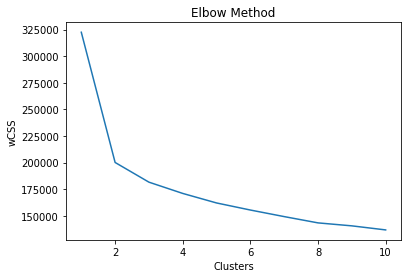

In [31]:
wCSS = []
for i in range(1,11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10)
    kmeans.fit(data_scaled)
    wCSS.append(kmeans.inertia_) #Collects all of the within cluster sum of squares
plt.plot(range(1,11), wCSS)
plt.title('Elbow Method')
plt.xlabel('Clusters')
plt.ylabel('wCSS')
plt.show()

## Descision Trees With Boosting

In [32]:
#first without scaling target
#      check for stationarity in target
#first without introducing lagged features

In [33]:
data_scaled.columns

Index(['log_price', 'bp1', 'bs1', 'bp2', 'bs2', 'bp3', 'bs3', 'bp4', 'bs4',
       'bp5',
       ...
       'First2OFI_trend100', 'First2OFI_trend200', 'First2OFI_trend1000',
       'FDOFI_trend5', 'FDOFI_trend10', 'FDOFI_trend20', 'FDOFI_trend50',
       'FDOFI_trend100', 'FDOFI_trend200', 'FDOFI_trend1000'],
      dtype='object', length=112)

In [34]:
train_size = 0.65
index = round(train_size*data_scaled.shape[0])
df_train = data_scaled.iloc[:index]
df_test = data_scaled.iloc[index:]

In [35]:
X_train = df_train.drop('realized_volatility', axis=1)
X_test = df_test.drop('realized_volatility', axis=1)

In [36]:
y = data.realized_volatility

In [37]:
from sklearn.ensemble import AdaBoostClassifier

In [38]:
model = AdaBoostClassifier(n_estimators=1)

In [39]:
model.fit(X_train,y_train)

NameError: name 'y_train' is not defined

In [ ]:
from sklearn.metrics import classification_report,plot_confusion_matrix,accuracy_score

In [ ]:
predictions = model.predict(X_test)

In [ ]:
print(classification_report(y_test,predictions))

In [ ]:
model.feature_importances_

In [ ]:
model.feature_importances_.argmax()

In [ ]:
X.columns[model.feature_importances_.argmax()]

In [ ]:
from xgboost import XGBClassifier
xgb_clf = XGBClassifier()
xgb_clf.fit(X_train, y_train)


In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier 

regr_1 = DecisionTreeClassifier(max_depth=4)

regr_2 = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=4), n_estimators=300, random_state=42
)

regr_1.fit(X, y)
regr_2.fit(X, y)

y_1 = regr_1.predict(X)
y_2 = regr_2.predict(X)

In [ ]:
data[['log_price']].boxplot();

In [ ]:
data[['WAP']].boxplot();

In [ ]:
data[['spread']].boxplot();

In [ ]:
data[['log_returns']].boxplot();

In [ ]:
data[['realized_volatility']].boxplot();

# Baseline Model: Time Series 

## Step 1: Create volatility levels

In [ ]:
pd.qcut(data['realized_volatility'],20).value_counts()

In [ ]:
plt.hist(data.realized_volatility, bins = 200);

In [ ]:
data['realized_volatility'].describe()

In [ ]:
data['volatility_levels'] = ['red' if x == 'Z' else 'green' for x in df['Set']]